In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("GSAF5.xlsx")

In [3]:
# Goal: Commit the perfect shark murder
# Problem Statement: Identify the correct location, activity, time of the day and what time of the year

# Hypothesis 1: The perfect location is Australia (can be narrowed down on state level if fitting to the country)
# Hypothesis 2: The perfect time of the year is early in the year on a morning
# Hypothesis 3: The deadliest sharks will be white, tiger and bull

# Columns we need: "Fatal Y/N", "Country", "Date", "Activity",  "Time"
# -> GFM: Fatal & Country
# -> LB: Date
# -> MB: Activty & Time


# further stuf:
# - age, gender of the person we try to kill
# species for "e.g should be killed by white shark"

In [4]:
df.columns

Index(['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity',
       'Name', 'Sex', 'Age', 'Injury', 'Fatal Y/N', 'Time', 'Species ',
       'Source', 'pdf', 'href formula', 'href', 'Case Number', 'Case Number.1',
       'original order', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

In [5]:
df.duplicated().sum()
# -> No duplicates


0

# Activity cleaning

In [6]:
# Goal: Commit the perfect shark murder
# Problem Statement: Identify the correct location, activity,  time of the day and what time of the year

df_time_activity_null = df[["Time", "Activity"]].isnull().mean()
activity_null = df_time_activity_null["Activity"]
print(f"Activity has {round(activity_null,2)*100}% empty values.")

Activity has 8.0% empty values.


In [7]:
# clean column from any typing mistakes
df.Activity = df.Activity.apply(lambda x: ' '.join(x.lower().split()).replace(" ", "_").replace("-","_") if isinstance(x,str) else x)

In [8]:
# summarise surfing activities into one
df.Activity = df.Activity.replace({"stand_up_paddleboarding":"surface_sport", "paddle_boarding":"surface_sport", "kite_surfing": "surface_sport","windsurfing":"surface_sport", "surf_skiing":"surface_sport","kayaking":"surface_sport","rowing":"surface_sport","canoeing":"surface_sport", "surfing":"surface_sport", "body_boarding": "surface_sport", "boogie_boarding": "surface_sport"})
#df['Activity'] = df['Activity'].str.replace(pat=r"(?i)(\S*surf\S*|\S*board\S*)", repl="surfing", regex=True)
# summarise diving activities
df['Activity'] = df['Activity'].str.replace(pat=r"(?i)(\S*dive\S*|\S*divi\S*)", repl="diving_activities", regex=True).replace({"diving":"diving_activities", "snorkeling":"diving_activities"})
# summarise bathing
df.Activity = df.Activity.replace({"walking":"swimming","wading":"swimming","playing":"swimming","floating_on_his_back": "swimming", "treading_water": "swimming", "body_surfing":"swimming", "bathing":"swimming", "standing":"swimming", "floating":"swimming"})
# summarise fishing
df['Activity'] = df['Activity'].str.replace(pat=r"(?i)(\S*fish\S*)", repl="fishing", regex=True)
# disaster
df.Activity = df.Activity.replace({"fell_overboard": "accident", "sea_disaster":"accident"})
# categorize other activities
df.Activity = df.Activity.apply(lambda x: x if x in ["surface_sport", "diving_activities", "swimming", "fishing", "accident"] else "unqualified")

In [9]:
df.Activity.value_counts().nlargest(20)

Activity
unqualified          1808
swimming             1641
surface_sport        1436
fishing              1286
diving_activities     786
accident               47
Name: count, dtype: int64

# Time Cleaning

In [10]:
time_null = df_time_activity_null["Time"]
print(f"Time has {round(time_null,2)*100}% empty values.")

Time has 50.0% empty values.


In [11]:
df['Time'] = df['Time'].replace(to_replace=r'(?i).*noon.*', value='Afternoon', regex=True)
df['Time'] = df['Time'].replace(to_replace=r'(?i).*morning.*', value='Morning', regex=True)
df['Time'] = df['Time'].replace(to_replace=r'(?i).*Night.*', value='Night', regex=True)
df.Time = df.Time.replace({"P.M.":"Afternoon", "A.M.":"Morning", "Dusk":"Morning", "Midday": "Afternoon"})

In [12]:
def categorize_time(time):
    if pd.isna(time) or time == "?":
        return "Unknown"
    try:
        hour = int(time[:2])
        if 6 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 18:
            return "Afternoon"
        elif 18 <= hour < 22:
            return "Evening"
        else:
            return "Night"
    except:
        return time

# Columns we need: "Fatal Y/N", "Country", "Date", "Activity",  "Time"
# -> GFM: Fatal & Country
# -> LB: Date
# -> MB: Activty & Time


# further stuf:
# - age, gender of the person we try to kill
# species for "e.g should be killed by white shark"





In [13]:
def clean_date_column(df, column_name, date_format='%Y-%m-%d', fill_na=None):
    """
    Cleans a date column in a DataFrame and returns both cleaned and invalid rows.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the date column.
    - column_name (str): The name of the date column to clean.
    - date_format (str, optional): The format to standardize the date to (default: '%Y-%m-%d').
    - fill_na (str or pd.Timestamp, optional): A default date to fill missing/invalid values. If None, does not fill.

    Returns:
    - pd.DataFrame: The DataFrame with the cleaned date column.
    - pd.DataFrame: A DataFrame containing rows that had invalid dates.
    - dict: A summary of how many rows were affected.
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Convert column to datetime, coercing errors to NaT
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')

    # Separate valid and invalid date rows
    valid_df = df[df[column_name].notna()].copy()
    invalid_df = df[df[column_name].isna()].copy()

    # Count invalid dates
    invalid_count = len(invalid_df)

    # Handle missing values in valid_df
    if fill_na is not None:
        valid_df[column_name] = valid_df[column_name].fillna(pd.Timestamp(fill_na))

    # Standardize date format
    valid_df[column_name] = valid_df[column_name].dt.strftime(date_format)

    # Summary of changes
    summary = {
        "total_rows": len(df),
        "valid_rows": len(valid_df),
        "invalid_rows": invalid_count,
        "filled_rows": invalid_count if fill_na else 0
    }

    print("Date Cleaning Summary:", summary)
    
    return valid_df, invalid_df, summary

# cleaned_df, invalid_df, summary = clean_date_column(df, 'Date')

# print("\nCleaned DataFrame:")
# display(cleaned_df)

# print("\nInvalid DataFrame:")
# display(invalid_df)


-----
# Guillermo Working on Cleaning  Fatal Y/N


In [14]:
# Code to clean the 'Fatal Y/N' column in the DataFrame

# Define a dictionary to map current values to 'Yes' or 'No'
'''replacements = {
    'Y': 'Yes',
    'N': 'No',
    'UNKNOWN': 'No',  # Example of treating unknown as 'No', adjust as needed
    'nan': 'No',      # Handle missing values, adjust if they should be 'Yes' 
    # Add more mappings if necessary
}
'''
# Sample data as a list
values = ['N', 'Y', 'F', 'M', float('nan'), 'n', 'Nq', 'UNKNOWN', 2017, 'Y x 2', ' N', 'N ', 'y']

# Define a dictionary for the mappings
mapping = {
    'N': 'N',
    'Y': 'Y',
    'F': 'U',           # Assuming 'F' and 'M' are unusual entries we'll consider unknown ('U')
    'M': 'U',
    'n': 'N',
    'Nq': 'N',
    'UNKNOWN': 'U',
    2017: 'U',         # With the numerical could Keep numerical years unchanged or convert to 'U'
    'Y x 2': 'Y',       # Considering 'Y x 2' as a form of 'Yes'
    ' N': 'N',
    'N ': 'N',
    'y': 'Y'
}

# Apply the mapping to the column
df['Fatal Y/N'] = df['Fatal Y/N'].replace(mapping).fillna('U')

# Print the cleaned DataFrame column
# print(df['Fatal Y/N'].value_counts())


''' Sample data as a list
values = ['N', 'Y', 'F', 'M', float('nan'), 'n', 'Nq', 'UNKNOWN', 2017, 'Y x 2', ' N', 'N ', 'y']

different values in column fatal y/n:
 Fatal Y/N
N          4877
Y          1474
UNKNOWN      71
 N            7
F             5
M             3
n             1
Nq            1
2017          1
Y x 2         1
N             1
y             1
Name: count, dtype: int64
['N' 'Y' 'F' 'M' nan 'n' 'Nq' 'UNKNOWN' 2017 'Y x 2' ' N' 'N ' 'y']
Number of NaN values in 'Fatal Y/N' column: 561

The result is:

different values in column fatal y/n:
 Fatal Y/N
N    4887
Y    1476
U     641
Name: count, dtype: int64
['N' 'Y' 'U']
Number of NaN values in 'Fatal Y/N' column: 0'''




" Sample data as a list\nvalues = ['N', 'Y', 'F', 'M', float('nan'), 'n', 'Nq', 'UNKNOWN', 2017, 'Y x 2', ' N', 'N ', 'y']\n\ndifferent values in column fatal y/n:\n Fatal Y/N\nN          4877\nY          1474\nUNKNOWN      71\n N            7\nF             5\nM             3\nn             1\nNq            1\n2017          1\nY x 2         1\nN             1\ny             1\nName: count, dtype: int64\n['N' 'Y' 'F' 'M' nan 'n' 'Nq' 'UNKNOWN' 2017 'Y x 2' ' N' 'N ' 'y']\nNumber of NaN values in 'Fatal Y/N' column: 561\n\nThe result is:\n\ndifferent values in column fatal y/n:\n Fatal Y/N\nN    4887\nY    1476\nU     641\nName: count, dtype: int64\n['N' 'Y' 'U']\nNumber of NaN values in 'Fatal Y/N' column: 0"

----
# Cleaning Country:

In [15]:
# Strip leading/trailing whitespaces and convert to lowercase
df['Country'] = df['Country'].str.lower().str.strip()


In [16]:
# Replace NaN in the 'Country' column with 'unknown'
df['Country'] = df['Country'].fillna('unknown')


In [17]:
# 1st step: Clean the 'Country' column

# Create the 'Region' column because too many entries with regions instead of countries in the 'Country' column. 
# that way we can still use the data even if it more generalized. Also there are a lot of small islands that have to be research to know where are they located.

regions = [
    'atlantic ocean', 'pacific ocean', 'indian ocean', 'red sea', 'mediterranean sea',
    'caribbean sea', 'bay of bengal', 'gulf of aden', 'persian gulf', 'tasman sea',
    'south china sea', 'north atlantic ocean', 'south atlantic ocean', 'north pacific ocean',
    'south pacific ocean', 'southwest pacific ocean', 'central pacific', 'coral sea',
    'mid atlantic ocean', 'mid-pacifc ocean', 'between portugal & india', 'coast of africa',
    'the balkans', 'british isles', 'west indies', 'antarctica', 'ocean', 'africa',
    'europe', 'north america', 'south america', 'oceania', 'middle east', 'asia'
]
# Clean 'Country' by removing '?' and whitespace
df['Country_clean'] = df['Country'].str.replace('?', '', regex=False).str.strip()

# Initialize 'Region' as 'unknown'
df['Region'] = 'unknown'

# Identify rows where cleaned 'Country' is a region
is_region = df['Country_clean'].isin(regions)

# Update 'Region' and 'Country' for these rows
df.loc[is_region, 'Region'] = df.loc[is_region, 'Country_clean']
df.loc[is_region, 'Country'] = 'unknown'

# Drop the temporary 'Country_clean' column
df.drop(columns=['Country_clean'], inplace=True)

In [18]:
# Regroup regions and correct typos and more general regions
region_grouping = {
    # Ambiguous regions
    'british isles': 'northern europe',
    'ocean': 'unknown',
    'coast of africa': 'africa',
    'mid-pacifc ocean': 'pacific ocean',  # Corrected typo
    'between portugal & india': 'unknown',
    'the balkans': 'southeast europe',
    'mid atlantic ocean': 'atlantic ocean',
    'central pacific': 'pacific ocean',
    
    # Optional: Group smaller regions under continents
    'caribbean sea': 'caribbean',
    'bay of bengal': 'indian ocean',
    'gulf of aden': 'indian ocean',
    'persian gulf': 'middle east',
    'tasman sea': 'pacific ocean',
    'south china sea': 'pacific ocean',
    'mediterranean sea': 'mediterranean',
}
# Step 1: Correct typos (e.g., "mid-pacifc ocean" → "mid-pacific ocean")
df['Region'] = df['Region'].str.replace('pacifc', 'pacific')

# Step 2: Apply grouping
df['Region'] = df['Region'].replace(region_grouping)

# Step 3: Handle remaining ambiguous entries (e.g., "africa", "asia")
# Optional: If you want continents as regions, keep them. Otherwise:
continent_to_region = {
    'africa': 'africa',  # Keep if continents are valid regions for your analysis
    'asia': 'asia',
    'europe': 'europe',
    'north america': 'north america',
    'south america': 'south america',
}
df['Region'] = df['Region'].replace(continent_to_region)

In [19]:
# Get current column list
cols = df.columns.tolist()

# Remove 'Region' from its current position
cols.remove('Region')

# Find the position of 'Country' and insert 'Region' before it
country_position = cols.index('Country')
cols.insert(country_position, 'Region')

# Reorder the DataFrame
df = df[cols]

-------
Cleaning more the Country column

In [20]:
# 2nd version of country mapping (after taking out the regions)
country_mapping = {
    # Fix typos and variations
    'st kitts / nevis': 'saint kitts and nevis',
    'st. martin': 'saint martin',
    'st. maartin': 'saint martin',
    'st helena, british overseas territory': 'saint helena',
    'turks & caicos': 'turks and caicos',
    'ceylon (sri lanka)': 'sri lanka',
    'ceylon': 'sri lanka',
    'british isles': 'united kingdom',  # Preserve as a distinct entity
    'burma': 'myanmar',
    'western samoa': 'samoa',
    'british new guinea': 'papua new guinea',
    'andaman / nicobar islandas': 'andaman and nicobar islands',
    'andaman islands': 'andaman and nicobar islands',
    'johnston island': 'johnston atoll',  # Preserve as a distinct entity
    'british virgin islands': 'virgin islands',  # Preserve as a distinct entity
    'netherlands antilles': 'netherlands antilles',  # Preserve as a distinct entity
    'san domingo': 'dominican republic',
    'grand cayman': 'cayman islands',  # Preserve as a distinct entity
    'coast of africa': 'africa',  # Preserve as a distinct entity
    'red sea / indian ocean': 'indian ocean',  # Preserve as a distinct entity
    # 'between portugal & india': 'between portugal and india',  # Preserve as a distinct entity
    # 'ocean': 'ocean',  # Preserve as a distinct entity
    # 'unknown': 'unknown',

    # Fix misspellings without grouping
    'columbia': 'colombia',
    
    'united arab emirates (uae)': 'united arab emirates',
    'solomon islands / vanuatu': 'solomon islands and vanuatu',
    'trinidad & tobago': 'trinidad and tobago',
                                                # Countries with double country 
    'egypt / israel': 'egypt',           # Egypt is often in total
    'equatorial guinea / cameroon': 'equatorial guinea',
    'iran / iraq': 'iran',
    'italy / croatia': 'italy',
    # 'red sea / indian ocean': 'red sea and indian ocean',
    # 'mid-pacifc ocean': 'mid-pacific ocean',
    # 'the balkans': 'the balkans',  # Preserve as a distinct entity
}

# Apply the mapping to the 'Country' column
df['Country'] = df['Country'].replace(country_mapping)

print(df['Country'].unique())

['australia' 'bahamas' 'turks and caicos' 'mozambique' 'usa'
 'new caledonia' 'egypt' 'thailand' 'new zealand' 'maldives' 'hawaii'
 'honduras' 'indonesia' 'morocco' 'jamaica' 'belize' 'maldive islands'
 'french polynesia' 'tobago' 'india' 'trinidad' 'south africa' 'mexico'
 'philippines' 'unknown' 'spain' 'portugal' 'samoa' 'colombia' 'ecuador'
 'cuba' 'brazil' 'seychelles' 'argentina' 'fiji' 'england' 'japan'
 'costa rica' 'british overseas territory' 'canada' 'jordan'
 'saint kitts and nevis' 'st martin' 'papua new guinea' 'reunion island'
 'israel' 'china' 'ireland' 'italy' 'malaysia' 'libya' 'mauritius'
 'solomon islands' 'saint helena' 'comoros' 'reunion' 'united kingdom'
 'united arab emirates' 'cape verde' 'dominican republic' 'cayman islands'
 'aruba' 'puerto rico' 'greece' 'saint martin' 'france'
 'trinidad and tobago' 'kiribati' 'diego garcia' 'taiwan'
 'palestinian territories' 'guam' 'nigeria' 'tonga' 'scotland' 'croatia'
 'saudi arabia' 'chile' 'antigua' 'kenya' 'russia' '

In [21]:
region_mapping = {
    # Australia and Oceania
    'australia': 'australia and oceania',
    'new caledonia': 'australia and oceania',
    'new zealand': 'australia and oceania',
    'fiji': 'australia and oceania',
    'samoa': 'australia and oceania',
    'papua new guinea': 'australia and oceania',
    'solomon islands': 'australia and oceania',
    'vanuatu': 'australia and oceania',
    'kiribati': 'australia and oceania',
    'tonga': 'australia and oceania',
    'micronesia': 'australia and oceania',
    'marshall islands': 'australia and oceania',
    'palau': 'australia and oceania',
    'cook islands': 'australia and oceania',
    'french polynesia': 'australia and oceania',
    'american samoa': 'australia and oceania',
    'guam': 'australia and oceania',
    'northern mariana islands': 'australia and oceania',
    'new guinea': 'australia and oceania',
    'admiralty islands': 'australia and oceania',
    'johnston atoll': 'australia and oceania',

    # Caribbean
    'bahamas': 'caribbean',
    'turks and caicos': 'caribbean',
    'jamaica': 'caribbean',
    'cuba': 'caribbean',
    'dominican republic': 'caribbean',
    'cayman islands': 'caribbean',
    'aruba': 'caribbean',
    'puerto rico': 'caribbean',
    'saint kitts and nevis': 'caribbean',
    'saint martin': 'caribbean',
    'trinidad and tobago': 'caribbean',
    'barbados': 'caribbean',
    'grenada': 'caribbean',
    'antigua': 'caribbean',
    'virgin islands': 'caribbean',
    'haiti': 'caribbean',
    'belize': 'caribbean',
    'netherlands antilles': 'caribbean',
    'curacao': 'caribbean',

    # North America
    'usa': 'north america',
    'canada': 'north america',
    'mexico': 'north america',
    'greenland': 'north america',
    'bermuda': 'north america',

    # South America
    'brazil': 'south america',
    'argentina': 'south america',
    'colombia': 'south america',
    'ecuador': 'south america',
    'chile': 'south america',
    'peru': 'south america',
    'venezuela': 'south america',
    'uruguay': 'south america',
    'paraguay': 'south america',
    'guyana': 'south america',
    'falkland islands': 'south america',

    # Europe
    'spain': 'southern europe',
    'portugal': 'southern europe',
    'greece': 'southern europe',
    'italy': 'southern europe',
    'malta': 'southern europe',
    'croatia': 'southern europe',
    'montenegro': 'southern europe',
    'slovenia': 'southern europe',
    'france': 'western europe',
    'united kingdom': 'western europe',
    'ireland': 'western europe',
    'iceland': 'northern europe',
    'norway': 'northern europe',
    'sweden': 'northern europe',
    'azores': 'western europe',
    'cyprus': 'southern europe',
    'crete': 'southern europe',

    # Africa
    'egypt': 'northern africa',
    'morocco': 'northern africa',
    'libya': 'northern africa',
    'tunisia': 'northern africa',
    'algeria': 'northern africa',
    'south africa': 'southern africa',
    'mozambique': 'southern africa',
    'madagascar': 'southern africa',
    'mauritius': 'southern africa',
    'seychelles': 'southern africa',
    'comoros': 'southern africa',
    'reunion': 'southern africa',
    'reunion island': 'southern africa',
    'saint helena': 'southern africa',
    'angola': 'central africa',
    'cameroon': 'central africa',
    'gabon': 'central africa',
    'equatorial guinea': 'central africa',
    'kenya': 'eastern africa',
    'tanzania': 'eastern africa',
    'somalia': 'eastern africa',
    'ethiopia': 'eastern africa',
    'djibouti': 'eastern africa',
    'senegal': 'western africa',
    'nigeria': 'western africa',
    'ghana': 'western africa',
    'liberia': 'western africa',
    'sierra leone': 'western africa',
    'cape verde': 'western africa',
    'namibia': 'southern africa',
    'sudan': 'northern africa',
    'sudan?': 'northern africa',

    # Asia
    'india': 'south asia',
    'sri lanka': 'south asia',
    'maldives': 'south asia',
    'maldive islands': 'south asia',
    'bangladesh': 'south asia',
    'pakistan': 'south asia',
    'iran': 'middle east',
    'iraq': 'middle east',
    'saudi arabia': 'middle east',
    'yemen': 'middle east',
    'jordan': 'middle east',
    'lebanon': 'middle east',
    'syria': 'middle east',
    'kuwait': 'middle east',
    'united arab emirates': 'middle east',
    'qatar': 'middle east',
    'oman': 'middle east',
    'israel': 'middle east',
    'palestinian territories': 'middle east',
    'turkey': 'middle east',
    'china': 'east asia',
    'japan': 'east asia',
    'south korea': 'east asia',
    'north korea': 'east asia',
    'taiwan': 'east asia',
    'hong kong': 'east asia',
    'thailand': 'southeast asia',
    'malaysia': 'southeast asia',
    'singapore': 'southeast asia',
    'indonesia': 'southeast asia',
    'philippines': 'southeast asia',
    'vietnam': 'southeast asia',
    'myanmar': 'southeast asia',
    'cambodia': 'southeast asia',
    'laos': 'southeast asia',
    'brunei': 'southeast asia',

    # Pacific
    'hawaii': 'pacific',
    'okinawa': 'pacific',
    'new britain': 'pacific',
    'java': 'pacific',
    'solomon islands and vanuatu': 'pacific',
    'federated states of micronesia': 'pacific',

    # Other
    'unknown': 'unknown',
    'indian ocean': 'indian ocean',
    'northern arabian sea': 'indian ocean',
    'north sea': 'north sea',
    'atlantic ocean': 'atlantic ocean',
    'pacific ocean': 'pacific ocean',
    'mediterranean sea': 'mediterranean',
}

# Apply the mapping to create/update the 'Region' column
df['Region'] = df['Country'].map(region_mapping)

# Fill any missing values with 'unknown'
df['Region'] = df['Region'].fillna('unknown')

----
# Guillermo Working code:

In [26]:
# Hypothesis 1: location x fatal
# Test with chi² and cramer’s v
# Or eventually heat map

df_fatal = df[df["Fatal Y/N"] == "Y"]


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

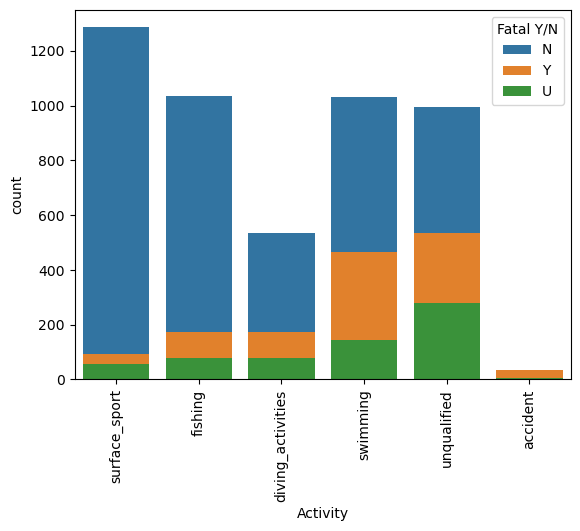

In [35]:
sns.countplot(df, x="Activity", hue="Fatal Y/N", dodge=False)
plt.xticks(rotation=90)
plt.show()

In [40]:
df_crosstab = pd.crosstab(df["Fatal Y/N"], df.Activity)

In [41]:
df_crosstab

Activity,accident,diving_activities,fishing,surface_sport,swimming,unqualified
Fatal Y/N,,,,,,
N,9,533,1035,1285,1032,993
U,4,78,78,57,144,280
Y,34,175,173,94,465,535


In [ ]:
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(df_crosstab)

chi2_statistic, chi2_p_value

(664.4038201644945, 2.736439338973053e-136, 10)

In [45]:
association(df_crosstab, method="cramer")

0.217785014843107

In [49]:
df_crosstab_normalized = df_crosstab.apply(lambda x: x / x.sum(), axis=0)
df_crosstab_normalized

Activity,accident,diving_activities,fishing,surface_sport,swimming,unqualified
Fatal Y/N,,,,,,
N,0.191489,0.678117,0.804821,0.894847,0.628885,0.549226
U,0.085106,0.099237,0.060653,0.039694,0.087751,0.154867
Y,0.723404,0.222646,0.134526,0.065460,0.283364,0.295907
